In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model = 'gpt-4o')
small_llm = ChatOpenAI(model = 'gpt-4o-mini')

In [3]:
from langchain_core.tools import tool

@tool
def add(a: int, b: int) -> int:
    """숫자 a와 b를 더합니다."""
    return a + b

@tool
def multiply(a: int, b: int) -> int:
    """숫자 a와 b를 곱합니다."""
    return a * b


In [4]:
# 도구 추가 1
from langchain_community.tools import DuckDuckGoSearchRun
search_tool = DuckDuckGoSearchRun()

In [5]:
# 도구 추가 2
from langchain_google_community import GmailToolkit
# toolkit = GmailToolkit()

In [6]:
from langchain_google_community.gmail.utils import (
    build_resource_service,
    get_gmail_credentials,
)
# Can review scopes here https://developers.google.com/gmail/api/auth/scopes
# For instance, readonly scope is 'https://www.googleapis.com/auth/gmail.readonly'
credentials = get_gmail_credentials(
    token_file="./google/gmail_token.json",
    scopes=["https://mail.google.com/"],
    client_secrets_file="./google/gmail_credentials.json",
)
api_resource = build_resource_service(credentials=credentials)
gmail_toolkit = GmailToolkit(api_resource=api_resource)
gmail_tool_list = gmail_toolkit.get_tools()

In [7]:
gmail_tool_list

[GmailCreateDraft(api_resource=<googleapiclient.discovery.Resource object at 0x11a97cad0>),
 GmailSendMessage(api_resource=<googleapiclient.discovery.Resource object at 0x11a97cad0>),
 GmailSearch(api_resource=<googleapiclient.discovery.Resource object at 0x11a97cad0>),
 GmailGetMessage(api_resource=<googleapiclient.discovery.Resource object at 0x11a97cad0>),
 GmailGetThread(api_resource=<googleapiclient.discovery.Resource object at 0x11a97cad0>)]

In [8]:
from langchain.agents import load_tools
loaded_tool_list = load_tools(
    ["arxiv"],
)

In [9]:
from langgraph.prebuilt import ToolNode

tool_list = [add, multiply, search_tool] + gmail_tool_list + loaded_tool_list
llm_with_tools = llm.bind_tools(tool_list)
tool_node = ToolNode(tool_list)

In [10]:
from langgraph.graph import MessagesState, StateGraph

graph_builder = StateGraph(MessagesState)

In [11]:
def agent(state: MessagesState) -> MessagesState:
    """
    에이전트 함수는 주어진 상태에서 메시지를 가져와
    LLM과 도구를 사용하여 응답 메시지를 생성

    Args:
        state (MessagesState): 메시지 상태를 포함하는 state.

    Returns:
        MessagesState: 응답 메시지를 포함하는 새로운 state.
    """
    # 상태에서 메시지를 추출합니다.
    messages = state['messages']
    
    # LLM과 도구를 사용하여 메시지를 처리하고 응답을 생성합니다.
    response = llm_with_tools.invoke(messages)
    
    # 응답 메시지를 새로운 상태로 반환합니다.
    return {'messages': [response]}

In [12]:
from typing import Literal
from langgraph.graph import END

# def should_continue(state: MessagesState) -> Literal['tools', END]:
#     """
#     주어진 메시지 상태를 기반으로 에이전트가 계속 진행할지 여부를 결정

#     Args:
#         state (MessagesState): `state`를 포함하는 객체.

#     Returns:
#         Literal['tools', END]: 도구를 사용해야 하면 `tools`를 리턴하고, 
#         답변할 준비가 되었다면 END를 반환해서 프로세스를 종료합니다.
#     """
#     # 상태에서 메시지를 추출합니다.
#     messages = state['messages']
    
#     # 마지막 AI 메시지를 가져옵니다.
#     last_ai_message = messages[-1]
    
#     # 마지막 AI 메시지가 도구 호출을 포함하고 있는지 확인합니다.
#     if last_ai_message.tool_calls:
#         # 도구 호출이 있으면 'tools'를 반환합니다.
#         return 'tools'
    
#     # 도구 호출이 없으면 END를 반환하여 프로세스를 종료합니다.
#     return END

In [13]:

graph_builder.add_node('agent', agent)
graph_builder.add_node('tools', tool_node)

In [14]:
from langgraph.graph import START, END
from langgraph.prebuilt import tools_condition # should_continue 와 같은 기능

graph_builder.add_edge(START, 'agent')
graph_builder.add_conditional_edges(
    'agent',
    tools_condition
    # should_continue,
    # ['tools', END]
)
graph_builder.add_edge('tools', 'agent')

In [15]:
graph = graph_builder.compile()

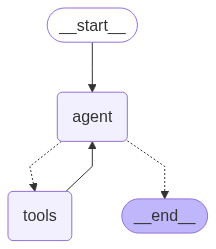

In [16]:
graph

In [17]:
from langchain_core.messages import HumanMessage

query = 'Attention is All you Need 라는 논문을 한글로 요약해서 iris122413@gmail.com 메일주소로 보내주세요.'
for chunk in graph.stream({'messages': [HumanMessage(query)]}, stream_mode='values'):
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

Attention is All you Need 라는 논문을 한글로 요약해서 iris122413@gmail.com 메일주소로 보내주세요.
================================== Ai Message ==================================
Tool Calls:
  arxiv (call_W5aTLjZt9kBRzPR2INeNSR3k)
 Call ID: call_W5aTLjZt9kBRzPR2INeNSR3k
  Args:
    query: Attention is All you Need
================================= Tool Message =================================
Name: arxiv

Published: 2024-07-22
Title: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models
Authors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini
Summary: The inference demand for LLMs has skyrocketed in recent months, and serving
models with low latencies remains challenging due to the quadratic input length
complexity of the attention layers. In this work, we investigate the effect of
dropping MLP and attention layers at inference time on the performance of
Llama-v2 

/Users/a202304035/llm_agent_practice/.venv/lib/python3.13/site-packages/langchain_community/utilities/duckduckgo_search.py:64: UserWarning: 'api' backend is deprecated, using backend='auto'
  ddgs_gen = ddgs.text(


================================= Tool Message =================================
Name: duckduckgo_search

2023. 8. 14. ... that proposes a new neural network architecture for sequence-to-sequence tasks, called the Transformer model. The paper challenges the ... "Attention Is All You Need" is a 2017 landmark research paper in machine learning authored by eight scientists working at Google. The paper introduced a new ... 2023. 6. 6. ... 소개 Attention Is All You Need The dominant sequence transduction models are based on complex recurrent or convolutional neural networks in ... 2024. 10. 19. ... “Attention Is All You Need” is a landmark paper in the field of artificial intelligence. By moving away from sequential processing and focusing ... "Attention is All You Need"—this groundbreaking paper introduces the Transformer, a revolutionary neural network architecture that redefines sequence ...
================================== Ai Message ==================================
Tool Calls:
  duck

/Users/a202304035/llm_agent_practice/.venv/lib/python3.13/site-packages/langchain_community/utilities/duckduckgo_search.py:64: UserWarning: 'api' backend is deprecated, using backend='auto'
  ddgs_gen = ddgs.text(


================================= Tool Message =================================
Name: duckduckgo_search

2023. 6. 6. ... 소개 Attention Is All You Need The dominant sequence transduction models are based on complex recurrent or convolutional neural networks in ... 2022. 2. 20. ... Transformer는 최근 들어 자연어 처리와 비전 분야 모두에서 월등한 성능을 보이면서 발전하고 있다. 이러한 Transformer를 처음으로 제안한 논문이 ... 2022. 3. 23. ... "Attention is all you need" (너가 필요한것은 Attention 이 전부다.) 논문의 제목에서 알 수 있듯이, 이 논문 즉 Transformer의 핵심 키워드는 ... 2025. 6. 21. ... Attention Is All You Need ; 논문 저자. Ashish Vaswani, et al. ; 분야. NLP ; 발표 년도. 2017 ; 논문 링크 ... 2021. 9. 17. ... 오늘 리뷰할 논문은 구글 리서치팀에서 발표한 "Attention is all you need"(링크)이다. 해당 논문은 현대 NLP의 중요한 backbone으로 사용되는 ...
================================== Ai Message ==================================

"Attention Is All You Need"는 2017년 구글 연구원들이 발표한 논문으로, 시퀀스-투-시퀀스 작업을 위한 새로운 신경망 아키텍처인 Transformer를 제안합니다. 이 논문은 기존의 복잡한 순환 신경망이나 합성곱 신경망 기반의 모델에서 벗어나, 순차 처리 대신 '어텐션' 메커니즘에 집중하여 혁신적인 변화를 이루어냈습니다.

In [21]:
query = 'Improving LLM-powered Recommendations with Personalized Information 라는 논문을 한글로 요약해서 iris122413@gmail.com 메일주소로 보내주세요.'
for chunk in graph.stream({'messages': [HumanMessage(query)]}, stream_mode='values'):
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

Improving LLM-powered Recommendations with Personalized Information 라는 논문을 한글로 요약해서 iris122413@gmail.com 메일주소로 보내주세요.
================================== Ai Message ==================================
Tool Calls:
  arxiv (call_H78ZZYxhh8uL70Vzt97iLweD)
 Call ID: call_H78ZZYxhh8uL70Vzt97iLweD
  Args:
    query: Improving LLM-powered Recommendations with Personalized Information
================================= Tool Message =================================
Name: arxiv

Published: 2024-10-13
Title: Analysis and Design of a Personalized Recommendation System Based on a Dynamic User Interest Model
Authors: Chunyan Mao, Shuaishuai Huang, Mingxiu Sui, Haowei Yang, Xueshe Wang
Summary: With the rapid development of the internet and the explosion of information,
providing users with accurate personalized recommendations has become an
important research topic. This paper designs and analyzes a personalized
recommen

In [18]:
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings
from langchain_core.tools.retriever import create_retriever_tool

# 최초 생성시
embeddings = OpenAIEmbeddings(model = 'text-embedding-3-large')
vector_store = Chroma(collection_name= 'real_estate_tax',
    persist_directory='./real_estate_tax_collection', embedding_function= embeddings)

retriever = vector_store.as_retriever(search_kwargs = {'k':3})
retriever_tool = create_retriever_tool(
    retriever = retriever,
    name ='real_estate_tax_retriever',
    description = 'Contains information about real estate tax up to December 2024'
)


In [19]:
from langgraph.prebuilt import ToolNode

tool_list = [add, multiply, search_tool, retriever_tool] + gmail_tool_list + loaded_tool_list
llm_with_tools = llm.bind_tools(tool_list)
tool_node = ToolNode(tool_list)

In [20]:
from langchain_core.messages import HumanMessage

query = '15억 짜리 아파트를 자가로 소유하고 있을 때 종합부동산세를 계산해주세요.'
for chunk in graph.stream({'messages': [HumanMessage(query)]}, stream_mode='values'):
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

15억 짜리 아파트를 자가로 소유하고 있을 때 종합부동산세를 계산해주세요.
================================== Ai Message ==================================
Tool Calls:
  real_estate_tax_retriever (call_Eu0xs2uaSdiVUnS418d2sOLe)
 Call ID: call_Eu0xs2uaSdiVUnS418d2sOLe
  Args:
    query: 15억 아파트 종합부동산세 계산
================================= Tool Message =================================
Name: real_estate_tax_retriever

Error: real_estate_tax_retriever is not a valid tool, try one of [add, multiply, duckduckgo_search, create_gmail_draft, send_gmail_message, search_gmail, get_gmail_message, get_gmail_thread, arxiv].
================================== Ai Message ==================================
Tool Calls:
  duckduckgo_search (call_KmCBrwXErTQC27oz4GuuKz3M)
 Call ID: call_KmCBrwXErTQC27oz4GuuKz3M
  Args:
    query: 15억 아파트 종합부동산세 계산 2024


/Users/a202304035/llm_agent_practice/.venv/lib/python3.13/site-packages/langchain_community/utilities/duckduckgo_search.py:64: UserWarning: 'api' backend is deprecated, using backend='auto'
  ddgs_gen = ddgs.text(


================================= Tool Message =================================
Name: duckduckgo_search

1억 5천만원 이하, 6만원+6천만원 초과금액의 0.15%, 3만원+6천만원 초과금액의 0.1%. 2024. 9. 19. ... 산출세액=(과세표준× 세율-누진공제)-공제할 재산세액*(｢지방세법｣§ 112조1항 2호는 제외.이하동일). * 해당연도 재산세로 부과된 세액의 합계액 ×. 과세 ... 2024. 4. 1. ... 2024년 기준으로 과세기준금액은 주택 9억, 1세대1주택은 12억, 종합합산토지 5억, 별도합산토지 80억입니다. 즉 과세 기준금액을 넘지 않은 부동산 ... 종합부동산세 세율 ; 3억 원 이하, 0.6%, 3억 원 이하, 1.2%, 15억 원 이하 ... 15억원 이하, 1%. 45억원 이하, 2%. 45억원 초과, 3%. 다. 별도합산. 별도합산. 과세표준 ... 종합부동산세 산출세액 계산은? 산출세액=(과세표준 × 세율 - 누진공제 ...
================================== Ai Message ==================================

2024년 기준으로 종합부동산세(종부세) 계산 방법은 다음과 같습니다. 주택의 경우 과세 기준금액은 1세대 1주택자 기준 12억 원입니다. 따라서 15억 원짜리 아파트는 과세 대상이 됩니다.

세율은 과세표준에 따라 다르게 적용됩니다. 15억 원 이하의 경우 세율은 1%로 적용됩니다.

- 종부세 산출세액 계산 공식: (과세표준 × 세율 - 누진공제)

그러나 실제 과세표준은 공시가격에서 일정 비율을 차감한 금액이 되며, 실제 공제할 재산세액 등 여러 요인들이 포함되어 계산됩니다. 정확한 계산을 위해서는 세무 전문가와 상담하시거나, 국세청 등의 공식 계산기를 이용하시는 것이 좋습니다.
